## Final Challenge

Here are some of the things we did during the class in the final challenge, and some extra things I finished after the workshop

You can download the file I generated by using this link:

https://www.dropbox.com/scl/fi/8ppcct0ytvrxxy7ppmb2a/Habituation_Short.parquet?rlkey=kvrnm3w088o3dvxiihfvbkhui&dl=0

### Grouped means

In [30]:
import dask.dataframe as dd
import timeit
ddf = dd.read_parquet('Habituation_Short.parquet')
print("Number of partitions in the Dask DataFrame:", ddf.npartitions)
print(ddf.head(2))  # Display the first few rows of the Dask DataFrame
grouped = ddf.groupby('Exp')['SNMV'].mean()
# Compute the final result (this triggers the execution of the task graph)
result = grouped.compute()
print("\nMean of 'SNM' for each 'Exp':",result)

Number of partitions in the Dask DataFrame: 13
      fishx     fishy     fishz  Burst  DHeadBurst  ElapsedTime  Exp  \
0 -0.094521  0.028841 -0.016522      1         NaN         0.00    1   
1 -0.092542  0.028552 -0.016124      0         NaN         0.02    1   

     Radius  SignedDHeadBurst       SNM  Speed  Speed3D  stimuli    trial  \
0  0.098823               NaN  0.096426    NaN      NaN      0.0  10000.0   
1  0.096846               NaN  0.116126    NaN      NaN      0.0  10000.0   

       SNMV  SpeedMean  
0  0.472089   0.065427  
1  0.449578   0.065427  

Mean of 'SNM' for each 'Exp': Exp
1      0.194440
2     -0.083676
3      0.533400
4     -0.377096
5     -0.205493
         ...   
219    0.138605
220   -0.040913
221    0.436615
222    0.130396
223   -0.005307
Name: SNMV, Length: 211, dtype: float64


### Benchmarking different partitions attempts

This might take 30min depending on the computer

In [1]:
import dask.dataframe as dd
import timeit
def bench_this(i):
    ddf = dd.read_parquet('Habituation_Short.parquet')
    ddf=ddf.repartition(npartitions=i)
    grouped = ddf.groupby('Exp')['SNM'].mean()
    # Compute the final result (this triggers the execution of the task graph)
    result = grouped.compute()
times_naive = []
runs=5
repeats=10
for i in range(1, 20):
    t=timeit.repeat('bench_this(i)', globals=globals(), number=runs, repeat=repeats)
    t=min(t)/runs
    print(i,t)
    times_naive.append(t)
    


1 1.608722304800176
2 1.2313809203995334
3 1.0516573888002312
4 0.9626310457999352
5 0.9716122542005905
6 0.988185412799794
7 1.0302027897996595
8 0.8243169428002147
9 0.7355905994001659
10 0.7644968856002379
11 0.7849720250000246
12 0.7835355921997689
13 0.7666307703999337
14 0.7817636650004716
15 0.7257856087999244
16 0.7839495211999747
17 0.8149624519995996
18 0.8127419636002742
19 0.7988491277996218
20 0.8239328331997967
21 0.8323061420000158
22 0.7988761423999676
23 0.8317294578002474
24 0.786162085399701
25 0.8208983080003236
26 0.8289749124000082
27 0.8017763026000466
28 0.819401380400086
29 0.8130537188000744


## Calculating Speed while using dask

While I was trying to write a code for calculating speed similar to what I did in Pandas, I started having some issues with the error msg `ValueError: cannot reindex on an axis with duplicate labels`

This happens due to the partitioning of the data. For simple operations like mean, min, max, etc. We can perform it in different partitions and then group them at the end and perform them one final time without any issues.

But with functions that are `order-dependent` like `shift`, `rolling`, `rank`, `sort_values`, you have to be sure that not only you are using group_by, but that your dask partition is being made according to those groups. To fix this we have to use a map_partition, and defining the meta, which is a description of every column and it's datatype in the set. Below there is a diagram explaining this

### Why we need *shuffle → map_partitions* and a matching **meta**

| problem we hit | what causes it | fix in the final pipeline |
|----------------|----------------|---------------------------|
| **Duplicate index error**<br>`ValueError: cannot reindex on an axis with duplicate labels` | Every Parquet row-group is read with a default `RangeIndex` starting at 0, so labels repeat across partitions. When we tried to assign `x_future` Dask/Pandas attempted to align by those labels and failed. | **`shuffle(['Exp','Trial'], ignore_index=True)`**<br>• Moves all rows of the same `(Exp, Trial)` into one partition **and**<br>• Rebuilds a fresh `RangeIndex` inside each output partition (`ignore_index=True`).<br>No duplicate labels ⇒ no re-index. |
| **Shift must see the whole group** | `groupby().shift()` is order-dependent; if a group is split across partitions the last `window` rows of one chunk can’t “see” the first rows of the next. | The same shuffle already puts every group in exactly one partition, so `shift(-14)` has the full ordered series. |
| **Strict schema check in *dask-expr***<br>`ValueError: columns in the computed data do not match…` | `map_partitions` returns a pandas **DataFrame**. dask-expr now requires the output columns (and their order) to match the *meta* you declare. | • We finish the function with `return pdf[cols]`, where `cols` lists columns in the desired order.<br>• We pass an explicit `meta` with **the same column order and dtypes**. The check passes. |



In [39]:
import pandas as pd, numpy as np, dask.dataframe as dd
FPS, window = 100, 14
ddf=dd.read_parquet("Habituation_Short.parquet")

def speed_block(pdf):
    g = pdf.groupby(['Exp','trial'])
    pdf['x_future'] = g['fishx'].shift(-window)
    pdf['y_future'] = g['fishy'].shift(-window)
    pdf['z_future'] = g['fishz'].shift(-window)
    pdf['t_future'] = g['ElapsedTime'].shift(-window)
    pdf['dx']       = pdf['x_future'] - pdf['fishx']
    pdf['dy']       = pdf['y_future'] - pdf['fishy']
    pdf['dz']       = pdf['z_future'] - pdf['fishz']
    pdf['dt']       = pdf['t_future'] - pdf['ElapsedTime']
    pdf['disp']     = np.sqrt(pdf['dx']**2 + pdf['dy']**2 + pdf['dz']**2)
    pdf['speedNew'] = pdf.disp / pdf.dt
    return pdf

# build a one-row DataFrame that lists the dtypes you expect
meta = pd.DataFrame({
    'fishx'       : pd.Series(dtype='float64'),
    'fishy'       : pd.Series(dtype='float64'),
    'fishz'       : pd.Series(dtype='float64'),
    'ElapsedTime' : pd.Series(dtype='float64'),
    'Exp'         : pd.Series(dtype='int64'),
    'Speed'       : pd.Series(dtype='int64'),
    'trial'       : pd.Series(dtype='int64'),
    'x_future'    : pd.Series(dtype='float64'),
    'y_future'    : pd.Series(dtype='float64'),
    'z_future'    : pd.Series(dtype='float64'),
    't_future'    : pd.Series(dtype='float64'),
    'dx'          : pd.Series(dtype='float64'),
    'dy'          : pd.Series(dtype='float64'),
    'dz'          : pd.Series(dtype='float64'),
    'dt'          : pd.Series(dtype='float64'),
    'disp'        : pd.Series(dtype='float64'),
    'speedNew'    : pd.Series(dtype='float64')
})

result = (
    ddf.drop(columns=['Burst', 'DHeadBurst','Radius','SignedDHeadBurst','SNM','Speed3D','stimuli','SNMV','SpeedMean'])
      .dropna(subset=['fishx', 'fishy', 'fishz','trial'])
      .shuffle(['Exp','trial'], ignore_index=True)   # one shuffle, fresh index
      .map_partitions(speed_block, meta=meta)        # <- correct callable/meta
      .compute()
)

print(result.head(15))


            fishx     fishy     fishz  ElapsedTime  Exp     Speed     trial  \
1293932 -0.047568 -0.062284 -0.060485      6194.01   22       NaN  250000.0   
1293933 -0.047584 -0.062023 -0.060485      6194.01   22       NaN  250000.0   
1293934 -0.047592 -0.061861 -0.060485      6194.01   22       NaN  250000.0   
1293935 -0.047591 -0.061798 -0.060485      6194.01   22       NaN  250000.0   
1293936 -0.047583 -0.061833 -0.060485      6194.01   22       NaN  250000.0   
1293937 -0.047566 -0.061967 -0.060485      6194.01   22       NaN  250000.0   
1293938 -0.047537 -0.062172 -0.060485      6194.01   22       NaN  250000.0   
1293939 -0.047447 -0.062398 -0.060456      6194.01   22  0.048523  250000.0   
1293940 -0.047363 -0.062765 -0.060275      6194.02   22  0.060864  250000.0   
1293941 -0.047362 -0.063313 -0.059998      6194.03   22  0.071911  250000.0   
1293942 -0.047477 -0.064085 -0.059721      6194.04   22  0.080441  250000.0   
1293943 -0.047720 -0.065099 -0.061823      6194.06  

In [48]:
print("Unique values of Exp in the result DataFrame:", result['Exp'].unique())

Unique values of Exp in the result DataFrame: [ 22  23  34  32  33  35  44  46  50  55  52  54  63 111 120 121 123 133
 137 139 143 150 147  62  69  86  87  97  99 106 149 154 156 162 166 165
 167 185 187 192 193 195  66  70  75  76  82  83  95 102 152 157 159 171
 172 177 180 200 206 208 219 220  15  21  26  30  39  38  45  47  48  57
  58 113 117 122 135 141 142 144 148 221  28  36  40  43  42  49  53  56
 110 115 116 126 136 138  85 107 104 105 158 184 188 203  24  27  31 118
 119 125 140  61  71  72  73  91  94  98 103 160 173 186 204 153 164 169
 179 181 196 201   3  10  18  29  51 124 132 146  68  96 101 210   5  14
  25  59 130 131  64  89  92  93 151 155 161 168 175 212 223   8 109 114
 134 145  80  88 176 183 197 198   2  17  37 108 112 129  81 214   4   6
  65  74  79 199  90 215 217  13  19  20 207 211 222   1  67  77 189 182
 190 209 218   9  11 127  78 194 205 216  60 128 100]


/tmp/ipykernel_3277/517585350.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot(speed_lists,    labels=labels, showfliers=False)
/tmp/ipykernel_3277/517585350.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(speedNew_lists, labels=labels, showfliers=False)


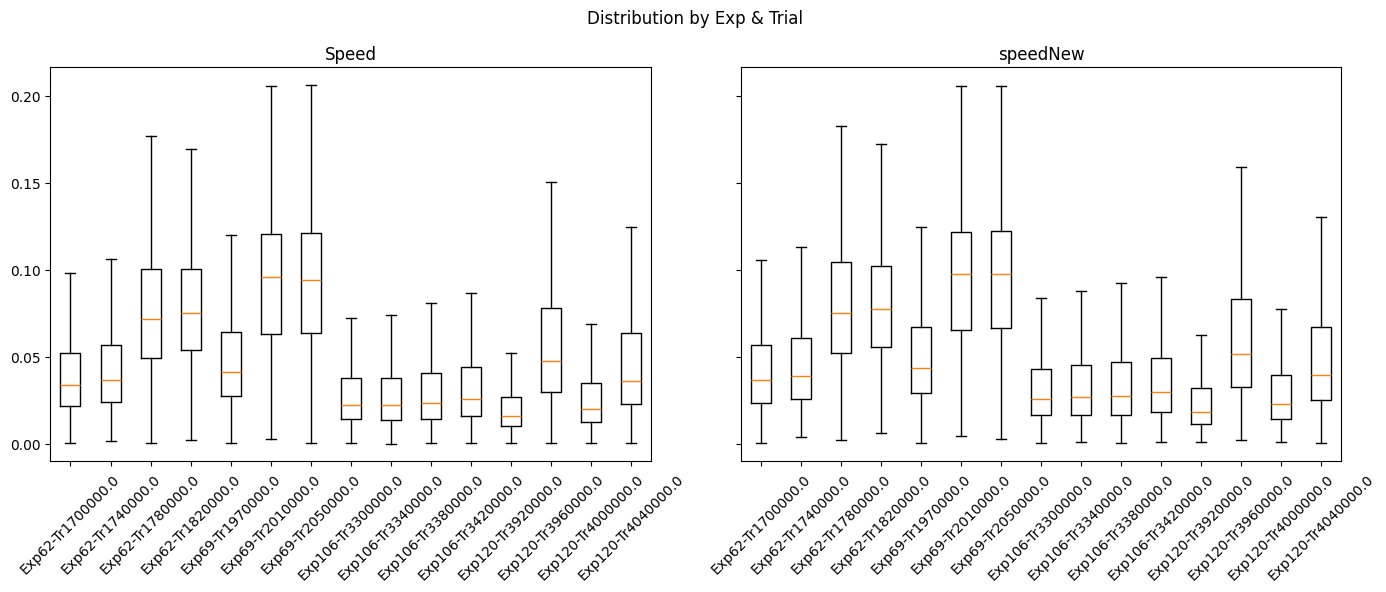

In [47]:
import matplotlib.pyplot as plt

ddf_sub = result[result['Exp'].isin([62,69, 106,120])].dropna(subset=['Speed','speedNew'])

grouped = (
    ddf_sub
      .groupby(['Exp','trial'])
      [['Speed','speedNew']]     # double brackets → list
      .agg(list)                 # gives a DataFrame of two list-columns
)

# build separate datasets
speed_lists     = grouped['Speed'].tolist()
speedNew_lists  = grouped['speedNew'].tolist()
labels = [f"Exp{e}-Tr{t}" for e, t in grouped.index]

fig, ax = plt.subplots(1, 2, figsize=(14,6), sharey=True)

ax[0].boxplot(speed_lists,    labels=labels, showfliers=False)
ax[0].set_title('Speed')
ax[0].tick_params(axis='x', rotation=45)

ax[1].boxplot(speedNew_lists, labels=labels, showfliers=False)
ax[1].set_title('speedNew')
ax[1].tick_params(axis='x', rotation=45)

fig.suptitle('Distribution by Exp & Trial')
fig.tight_layout()
plt.show()


In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
window=14
FPS=100

ddfV = dd.read_parquet('Artificial.parquet')
print("Number of partitions in the Dask DataFrame:", ddfV.npartitions)
ddfV['x_future'] = ddfV.groupby(['Exp', 'Trial'])['x'].shift(-window, meta=('x_future', 'f8'))
ddfV['y_future'] = ddfV.groupby(['Exp', 'Trial'])['y'].shift(-window, meta=('y_future', 'f8'))

# Compute differences in positions (dx and dy)
ddfV['dx'] = ddfV['x_future'] - ddfV['x']
ddfV['dy'] = ddfV['y_future'] - ddfV['y']

# Calculate the displacement vector magnitude.
ddfV['displacement'] = (ddfV['dx']**2 + ddfV['dy']**2)**0.5
# Compute speed using the formula:
ddfV['speedNew'] = FPS*ddfV['displacement'] / window
print('1')

# 2) Filter to Exp 1 & 4, select only the two columns, drop NaNs,
#    AND reset the index on *that* filtered frame in Dask:
ddf_sub = (
    ddfV[ddfV.Exp.isin([1,4])][["Exp","speedNew"]]
       .dropna()
       .map_partitions(
           lambda pdf: pdf.reset_index(drop=True),
           meta={"Exp":"i8","speedNew":"f8"}
       )
)
print('2')

# 3) Now it’s safe to compute into Pandas without duplicate‐index errors:
pdf = ddf_sub.compute()
print('3')

pdf = (
    ddfV[["Exp","speedNew"]]
      .dropna()                # drop any NaNs
      .compute()               # now in-memory Pandas DataFrame
      .reset_index(drop=True)  # reset to a clean integer Index
)

# 2) Grab only the two groups you care about and immediately strip away the index:
speeds_1 = (
    ddfV[ddfV.Exp == 1]['speedNew']
       .dropna()
       .to_dask_array()    # <— no `lengths` argument needed
       .compute()          # returns a plain numpy array
)
speeds_4 = (
    ddfV[ddfV.Exp == 4]['speedNew']
       .dropna()
       .to_dask_array()
       .compute()
)


# 2) Pull out the small slice you need (Exp 1 & 4):
ddf_sub = (
    ddfV[ddfV.Exp.isin([1,4])]
      [['Exp','speedNew']]
      .dropna()
)

# 3) Convert each group to a _Dask Array_ (no index to re‐align!)
#    Note lengths=False so it won’t even try to compute chunk lengths up front.
speeds_1 = ddf_sub[ddf_sub.Exp==1]['speedNew'].to_dask_array(lengths=False).compute()
speeds_4 = ddf_sub[ddf_sub.Exp==4]['speedNew'].to_dask_array(lengths=False).compute()




# Now pull speeds as a Dask Array, then compute it:
speeds_1 = ddfV[ddfV.Exp==1]['speedNew'].to_dask_array(lengths=True).compute()
speeds_4 = ddfV[ddfV.Exp==4]['speedNew'].to_dask_array(lengths=True).compute()

# 2) Compute each experiment’s speed array separately
speeds_1 = (ddfV[ddfV.Exp == 1]['speedNew'].dropna().compute().values)
speeds_4 = (ddfV[ddfV.Exp == 4]['speedNew'].dropna().compute().values)
print('1b')
ddf_sub = (
    ddfV[ddfV['Exp'].isin([1, 4])]
      [['Exp','speedNew']]
      .dropna()
)
print('1c')
# Force each partition to get a fresh unique index:
ddf_sub = ddf_sub.map_partitions(
    lambda pdf: pdf.reset_index(drop=True),
    meta={'Exp': 'i8', 'speedNew': 'f8'}
)
print('2')

speeds_1 = (
    ddf_sub[ddf_sub["Exp"] == 1]["speedNew"]  # pick Exp 1
       .dropna()                      # drop missing
       .compute()                     # load into pandas Series
       .values                        # get a 1D numpy array
)
print('3')
speeds_4 = (
    ddf_sub[ddf_sub["Exp"] == 4]["speedNew"]
       .dropna()
       .compute()
       .values
)
print('4')
# Now this will succeed without ValueError
pdf = ddf_sub.compute()
# 4) Now compute into Pandas safely
pdf = ddf_sub.compute()
pdf = pdf.reset_index(drop=True)

groups = pdf.groupby('Exp')['speedNew']
data = [grp.dropna().values for _, grp in groups]
labels = [str(exp) for exp, _ in groups]

# Plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels)
plt.xlabel('Experiment (Exp)')
plt.ylabel('Speed')
plt.title('Boxplot of Speed by Experiment')
plt.show()


Number of partitions in the Dask DataFrame: 4
1


/home/calovi/anconda32023/lib/python3.11/site-packages/dask/dataframe/methods.py:357: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df[name] = val


ValueError: cannot reindex on an axis with duplicate labels